# Deep Probabalistic Models: Tutorial 1
## Tutorial 1: Flow-Based Models and GAN

Welcome to the first tutorial for this week! This tutorial is a brief computational *exploration* of flow-based models and GANs within PyTorch. 

The goal of this tutorial is simple: for you to have you play around with flows and GANs on some simple examples (the full Iris data, and a swiss roll dataset).

This notebook has also been written in a manner that will serve as a nice reference implementation for you in the future. 

**N.B. Please be sure to run each code cell as your progress through the notebook.** 

# Flow-Based Models

## Guided Learning

In [1]:
import torch
import pyro
import matplotlib.pyplot as plt
import numpy as np 

torch.manual_seed(123)
plt.rcParams['figure.figsize'] = [12, 8]

The following code cell will import the famous "Iris" data. 

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

iris = load_iris()
dataset = iris.data
dataset = StandardScaler().fit_transform(dataset)

print(f"Dataset Loaded. Observations: {dataset.shape[0]:.0f}, dimension: {dataset.shape[1]:.0f}")

Dataset Loaded. Observations: 150, dimension: 4


**Flows typically fit quicker if the data is first standardized** (remove the sample mean and divide by sample variance for each column), so we do that below using a `StandardScaler` from `sklearn` 

In [3]:
from sklearn.preprocessing import StandardScaler
dataset = StandardScaler().fit_transform(dataset)

Run the code below to visualize the data with four different bivariate plots (visualizing two dimensions at a time). You will notice that the data has an interesting shape and thus will require a flexible model!

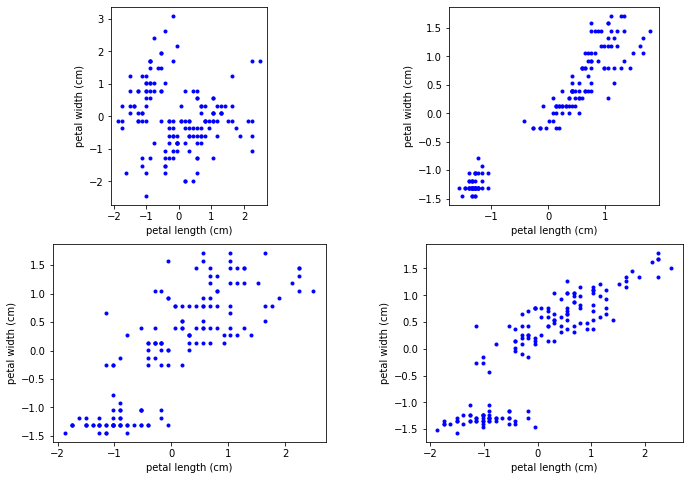

In [4]:
iter = [[0,1], [2,3], [0,3], [0,2]]
for i in range(4):
    plt.subplot(2,2,i+1, aspect='equal')
    ids = iter[i]
    plt.plot(dataset[:,ids[0]], dataset[:,ids[1]],'b.')
    plt.xlabel(iris.feature_names[2])
    plt.ylabel(iris.feature_names[3])

Next, we will fit a flow based model to the four-dimensional data (note that the figure in the lectures was only fit to the 2D data of petal length vs. petal width, so we are doing something a little different to that). 

The code below creates a 4D base distribution, as well as a single autoregressive transform with each of the four splines having 8 bins. 


In [5]:
import pyro.distributions as dist

p = 4 

# Specifies that Z ~ N(0,I)
distZ = dist.Normal(torch.zeros(4), torch.ones(4))

# Defines the Transformation 
T = pyro.distributions.transforms.spline_autoregressive(input_dim=p, hidden_dims=[20,20],
                                                        count_bins=8)

# Creates a distribution object which is Z transformed with the transformation T 
distX = dist.TransformedDistribution(distZ, [T])

The code below computes the total number of parameters used...

In [6]:
param_count = 0 
for param in T.parameters():
    param_count += len(param)
    
print("Total Parameters", param_count)    

Total Parameters 328


That is a **lot** of parameters for fitting a 4D density (by contrast, you can fit a mixture of two Gaussians with only 16!), but such is the nature of using neural networks. 

The `train_flow_model` function below takes five inputs: 

* `dataset` : this is a dataset in the form of a rectangular arrar (`numpy` or `torch.Tensor`)
* `params` : a collection of parameters which the optimizer will optimize over 
* `num_samples` : the number of subsampled observations from the data at each iteration
* `steps` : the total number of steps that the optimizer will take 
* `lr`: the learning rate parameter of the optimizer. Note that when deeper neural nets or longer flows are used, this will need to be set smaller to ensure stable training!

In [7]:
# Training the Flow Model           
def train_flow_model(dataset, params, num_samples=32, steps = 2501, lr = 1e-3):            
    dataset = torch.tensor(dataset, dtype=torch.float)
    optimizer = torch.optim.Adam(params, lr=lr)

    losslog = []
    for step in range(steps):
        optimizer.zero_grad()
        
        if num_samples == 'all':
            loss = -distX.log_prob(dataset).mean()
        else: 
            ids = np.random.choice(dataset.shape[0], num_samples) # randomly choose subsampling indices with replacement
            loss = -distX.log_prob(dataset[ids,:]).mean() # estimator of mean loss of training data (equivalent to using full log-likelihood in maximization)
        
        loss.backward()
        losslog.append(loss.item())
        optimizer.step()
        distX.clear_cache()

        if step % 250 == 0: print('step: {}, loss: {}'.format(step, loss.item()))
    
    return losslog

The code below will train the flow we set up for `Xdist` previously. It may take a minute or so depending on the number of steps and subsample batch size.

In [8]:
losslog = train_flow_model(dataset, params = T.parameters(), steps=5001, num_samples=64)    

step: 0, loss: 5.513051509857178
step: 250, loss: 3.270860433578491
step: 500, loss: 2.385253429412842
step: 750, loss: 1.7021130323410034
step: 1000, loss: 2.2837235927581787
step: 1250, loss: 1.6407891511917114
step: 1500, loss: 1.307382583618164
step: 1750, loss: 1.2717972993850708
step: 2000, loss: 0.7209160327911377
step: 2250, loss: 1.3088091611862183
step: 2500, loss: 0.9600974321365356
step: 2750, loss: 1.2893515825271606
step: 3000, loss: 1.2122917175292969
step: 3250, loss: 0.7893456220626831
step: 3500, loss: 1.5603080987930298
step: 3750, loss: 0.7705198526382446
step: 4000, loss: 0.6765570044517517
step: 4250, loss: 1.1983208656311035
step: 4500, loss: 0.8016637563705444
step: 4750, loss: 0.6877908706665039
step: 5000, loss: 0.6614512205123901


Plotting the (estimated) loss over time seems to imply that the training has converged.

**Pro Tip:** If training is not performing well, or is unstable, try reducing the learning rate, and/or increasing the number of subsamples used at each iteration. The former is typically required for deeper (more transforms) flows. 

Text(0, 0.5, 'Loss')

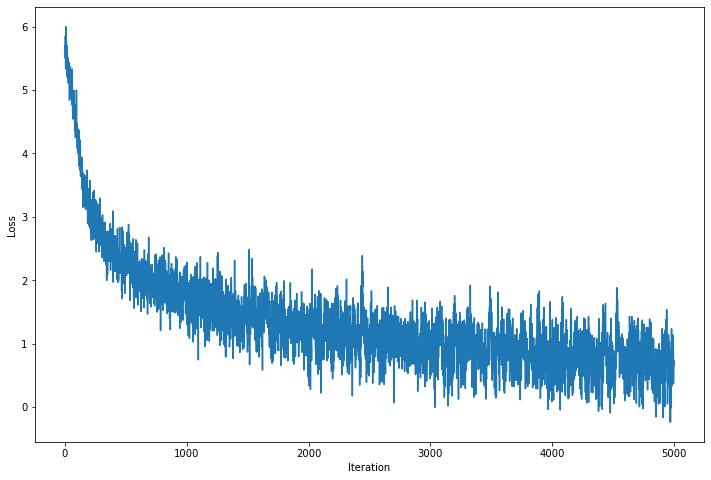

In [9]:
plt.plot(losslog)
plt.xlabel("Iteration")
plt.ylabel("Loss")

### Transformation Objects

Prior to looking at our fit, we will talk about how to use the transformation object we created that defines our distributional family. 

To create new data (or assess how well the original data gets transformed back to a normal), we wish to send samples through the learned $T$ and its inverse. 

Recall that we created a transformation object `T` above. 

Transformation objects have both a forward and inverse method defined on them. The following methods are worth noting: 


1. `T(Z)`: returns $T(Z)$
1. `T.inv(X)`: returns $T^{-1}(X)$

The above is demonstrated below by generating a sample $Z \sim {\cal N}(0,{\rm I})$, computing $X = T(Z)$, and then computing $Z = T^{-1}(X)$. Note that putting the sample through the transform and then the resulting sample through the inverse transform correctly yields the original sample back. 



In [10]:
Z = distZ.sample()
X = T(Z)
_Z = T.inv(X)
print('Z:', Z, '\nX = T(Z):', X, '\nT.inv(X):', _Z)

Z: tensor([ 0.0751, -0.6658,  0.5077, -1.9095]) 
X = T(Z): tensor([ 0.4773, -0.6224,  0.6354,  0.0989], grad_fn=<IndexPutBackward>) 
T.inv(X): tensor([ 0.0751, -0.6658,  0.5077, -1.9095])


The above also works with an arbitrary amount of samples. The `.sample` method of the base distribution just needs to be passed the requested number of samples inside of `[ ]`. Calling `distZ.sample()` is the same as `distZ.sample([1])`. Below, we generate 3 samples.

In [11]:
Z = distZ.sample([3])
X = T(Z)
_Z = T.inv(X)
print('Z:', Z, '\nX = T(Z):', X, '\nT.inv(X):', _Z)

Z: tensor([[ 0.1858,  0.7547, -0.0084, -0.5771],
        [-0.6839, -1.7994,  1.1301, -0.8738],
        [ 0.8142,  0.3064, -0.6114,  0.4796]]) 
X = T(Z): tensor([[ 0.0227, -0.1350,  0.2591,  0.2130],
        [ 0.7794, -1.1651,  1.1054,  0.6737],
        [-0.6858,  0.9392, -1.1832, -1.0730]], grad_fn=<IndexPutBackward>) 
T.inv(X): tensor([[ 0.1858,  0.7547, -0.0084, -0.5771],
        [-0.6839, -1.7994,  1.1301, -0.8738],
        [ 0.8142,  0.3064, -0.6114,  0.4796]])


Below, we sample 500 times from the learned distribution, and plot the observations in bivariate plots with the original data. 

In [12]:
X = distX.sample([500]).detach().numpy()

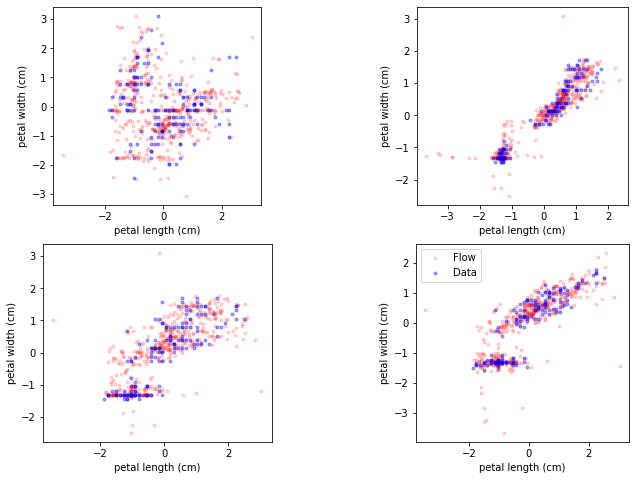

In [13]:

iter = [[0,1], [2,3], [0,3], [0,2]]
for i in range(4):
    plt.subplot(2,2,i+1, aspect='equal')
    ids = iter[i]
    plt.plot(X[:,ids[0]], X[:,ids[1]],'r.', label = "Flow", alpha=0.15)
    plt.plot(dataset[:,ids[0]], dataset[:,ids[1]],'b.', label = "Data", alpha=0.35)
    plt.xlabel(iris.feature_names[2])
    plt.ylabel(iris.feature_names[3])
plt.legend()

Note that, as is the case with minimizing $KL(p||q)$, the learned distribution is very conservative where it places mass. 

In [14]:
data_tensor = torch.tensor(dataset, dtype=torch.float)
dataZ = T.inv(data_tensor).detach().numpy()

If the model has fit the training data well, we should expect all the bivariate plots of the **inverse transformed** data to look like samples from a $N(\mathbf{0}, I)$ distribution. Below we plot the inverse transformed dataset, along with samples from a $N(\mathbf{0}, I)$ for comparison.

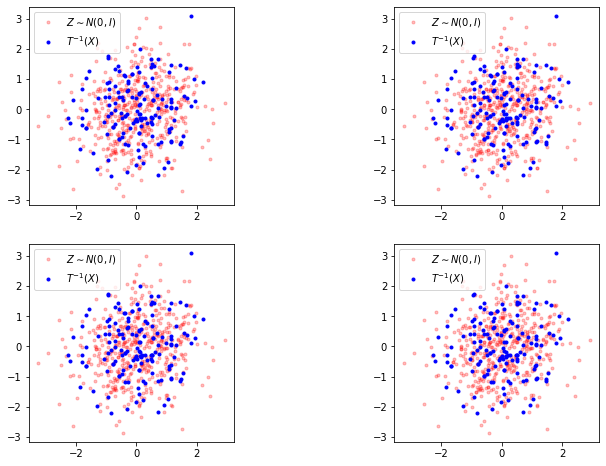

In [15]:
realZ = np.random.randn(500,4)

iter = [[0,1], [2,3], [0,3], [0,2]]
for i in range(4):
    plt.subplot(2,2,i+1, aspect='equal')
    ids = iter[i]
    plt.plot(realZ[:, 0], realZ[:,1], 'r.', alpha=0.25, label = '$Z \sim N(0,I)$',)
    plt.plot(dataZ[:, 0], dataZ[:,1], 'b.', alpha=1, label = '$T^{-1}(X)$')
    plt.legend()

## Multiple Transformations

For the next example, we will use multiple iterations of Real NVP with reverse permutation operations to fit data of a very challenging shape.


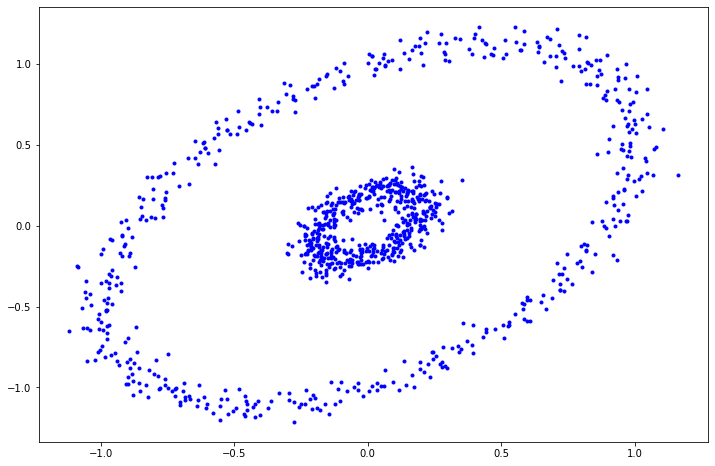

In [16]:
#plt.plot(test_data[:, 0], test_data[:,1], 'b.', alpha=0.05)

from sklearn.datasets import make_circles
import sklearn

_data = make_circles(n_samples=1000, factor=.2, noise=.05)[0]
_data_test = make_circles(n_samples=100, factor=.2, noise=.05)[0]

L = np.array([[1,0],[.5,1]])
data_circ = _data @ L.T
data_circ_test = _data_test  @ L.T

plt.plot(data_circ[:,0], data_circ[:,1], 'b.')

In this section, you will explore using flows of simpler transformations. The code below only does one Real NVP transformation, so it will leave half the variables unchanged as is. 

In [17]:
import pyro.distributions as dist
torch.manual_seed(123)

p = 2
distZ = dist.Normal(torch.zeros(p), torch.ones(p))

rev_perm = torch.tensor(range(p-1,-1,-1))

T=[]

main_transform = pyro.distributions.transforms.affine_coupling 

T.append(main_transform(input_dim = p, hidden_dims=[25]))    


n_layers = 1
for i in range(n_layers-1): # does not do this is n_layers=0
    T.append(dist.transforms.permute(input_dim=p, permutation=rev_perm))
    T.append(main_transform(input_dim = p, hidden_dims=[25]))
   
params = []
for tr in T: 
    if hasattr(tr, 'parameters'): params += list(tr.parameters())
        
distX = dist.TransformedDistribution(distZ, T)

T = torch.distributions.ComposeTransform(T) 


Note that training using Real NVP without splines is very fast!

In [18]:
# Training the Flow Model 

data = torch.tensor(data_circ, dtype=torch.float)
losslog = train_flow_model(dataset= data, params = params, num_samples=256, steps=10000, lr=1e-3)

/Users/rob/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


step: 0, loss: 2.2219951152801514
step: 250, loss: 1.7696082592010498
step: 500, loss: 1.870818018913269
step: 750, loss: 1.8138833045959473
step: 1000, loss: 1.7630712985992432
step: 1250, loss: 1.708415150642395
step: 1500, loss: 1.7100597620010376
step: 1750, loss: 1.7120732069015503
step: 2000, loss: 1.7740159034729004
step: 2250, loss: 1.7395192384719849
step: 2500, loss: 1.6691397428512573
step: 2750, loss: 1.7140744924545288
step: 3000, loss: 1.7218170166015625
step: 3250, loss: 1.6494301557540894
step: 3500, loss: 1.7656028270721436
step: 3750, loss: 1.7287485599517822
step: 4000, loss: 1.7604670524597168
step: 4250, loss: 1.737236499786377
step: 4500, loss: 1.7306638956069946
step: 4750, loss: 1.5943529605865479
step: 5000, loss: 1.641054391860962
step: 5250, loss: 1.7899681329727173
step: 5500, loss: 1.6804603338241577
step: 5750, loss: 1.748626470565796
step: 6000, loss: 1.7527351379394531
step: 6250, loss: 1.663804531097412
step: 6500, loss: 1.657233715057373
step: 6750, lo

Run the cell below to plot the result.Recall that the variable on the $x$-axis is marginally ${\cal N}(0,1)$ as we only used one layer of Real NVP!

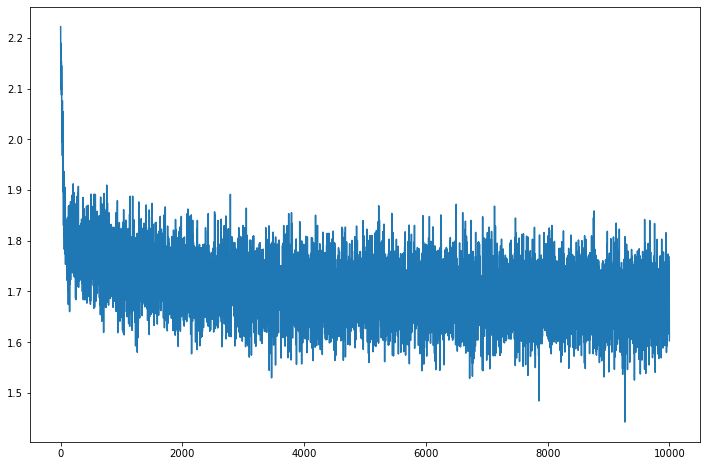

In [19]:
plt.plot(losslog)

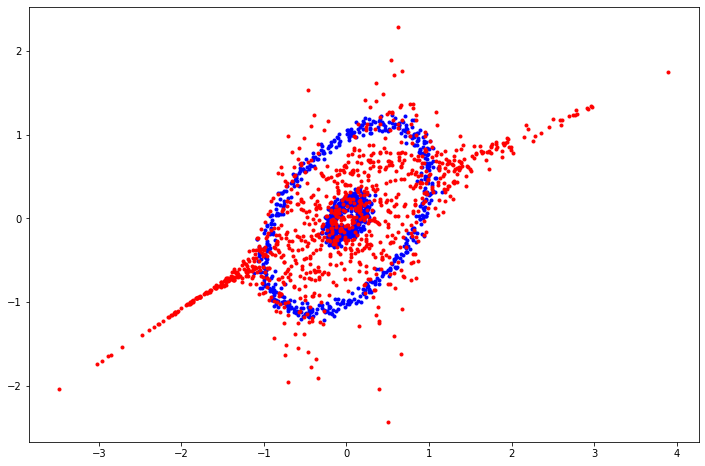

In [20]:
X = distX.sample([data_circ.shape[0]]).detach().numpy()
plt.plot(data_circ[:,0], data_circ[:,1], 'b.')
plt.plot(X[:,0], X[:,1], 'r.')



### Flow-Based Models: Exercise (Practical)

Modify the Real NVP flow code above and train it so you obtain a good fit to the points. 

You may wish to change:

* The **number of transforms** (layers) 
* The **number of hidden units** in the nueral nets (i.e., instead of [25], maybe [100]) in each layer. 
* The **number of hidden layers** in the neural nets (e.g., use [25,25,25] to have three hidden layers)
* A **different transform from Real NVP** (e.g., `pyro.distributions.affine_autoregressive` - but for a challenge, no splines are allowed!)
* The **learning rate** so training is more stable (this may necessitate more steps)
* The **random see**d (maybe after changing the above you have a good model and just got unlucky if you didn't get a good fit)

### Flow-Based Models: Exercise (Analytical) 

 **Johnson's SU-distribution** is a four-parameter one-dimensional distribution arising from the transformation of a standard normal:

$$X = \mu + \sigma \sinh\left(\frac{Z - \gamma}{\delta} \right)$$

where $\mu \in \mathbb{R}$, $\gamma \in \mathbb{R}$, $\sigma > 0$, $\delta >0$, and $Z \sim {\cal N}(0,1)$. 

Using that $\sinh^{-1}(x) = \log\left(x + \sqrt{x^2+1}\right)$, derive the probability density function of $X$ using the change of variables theorem.


## Generative Adversarial Networks

In this part of the tutorial, we will try to fit data from the **swiss roll** dataset using a GAN. As this dataset seems to follow the **manifold hypothesis** very well (data is a small perturbation from a 2D manifold in this case), we will try to fit it using a GAN which only has a dimension of two (2). We plot the same dataset viewed from two different angles. 

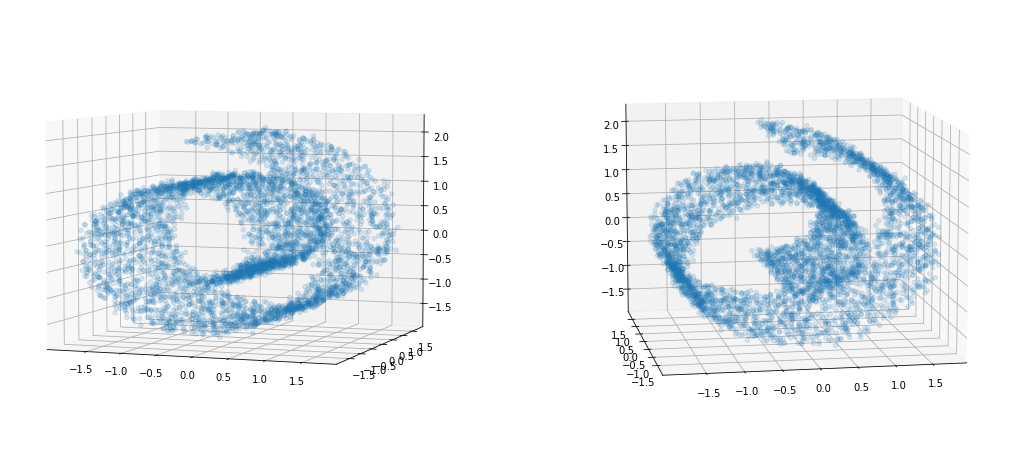

In [21]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

def plot3d(data):
    fig = plt.figure(figsize=(18, 10))
    ax = plt.subplot(1,2,1, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha = 0.15)
    ax.view_init(5, -70)

    ax = plt.subplot(1,2,2, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha = 0.15)
    ax.view_init(10, -100)

np.random.seed(123)
data, clr = make_swiss_roll(5000, random_state=100, noise = 0.3)

data = StandardScaler().fit_transform(data)
plot3d(data)


The class `manyGAN` implemented below contains implementations of GAN, NS-GAN, and Least Squares GANs. 

In [22]:
import torch as t
import torch.nn as nn

class manyGAN():
    def __init__(self, data, dimZ, n_hidden=50, GANtype = "GAN"):
        data_dim  = data.shape[1]
        self.dimZ = dimZ
        self.data = t.tensor(data, dtype=t.float) 
        self.n = data.shape[0]
        self.type = GANtype
        
        print("Latent Dimension", dimZ)
        print("Data Dimension:", data_dim)
        
        self.g = nn.Sequential(nn.Linear(dimZ, n_hidden), nn.ReLU(),
                               nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                               nn.Linear(n_hidden,data_dim))
        
        
        d_parts = [nn.Linear(data_dim, n_hidden),nn.ReLU(),
                   nn.Linear(n_hidden, n_hidden), nn.ReLU(),nn.Linear(n_hidden,1)]
    
        if GANtype in ["GAN", "NSGAN"]: d_parts.append(nn.Sigmoid())                       
        
        self.d = nn.Sequential(*d_parts) 
       
    def train_GAN(self, n_steps=20001,n_samples = 256, d_steps=1, lrs = [1e-4,2e-4], seed=1): 
        torch.manual_seed(seed)
        data = self.data
        
        self.opt_g = torch.optim.Adam(self.g.parameters(), lr=lrs[0])  
        self.opt_d = torch.optim.Adam(self.d.parameters(), lr=lrs[1])  
        
        self.glog = []
        self.dlog = []
        
        for i in range(n_steps):
            # ------------ train discriminator ---------------
            for j in range(d_steps):
                self.opt_d.zero_grad()
                X = self.g(t.randn(n_samples, self.dimZ) )
                ids = np.random.choice(data.shape[0],n_samples)
                if self.type in ["GAN", "NSGAN"]:
                    d_loss = -(t.mean(t.log(self.d(data))) + t.mean(t.log(1 - self.d(X))))
                elif self.type == "LSGAN":
                    d_loss = (t.mean((self.d(self.data)-1)**2) + t.mean(self.d(X)**2))/2
                          
                d_loss.backward() 
                self.dlog.append(d_loss.item())
                self.opt_d.step()
                    
            # ----------- train generator ------------------
            self.opt_g.zero_grad()
            X = self.g(t.randn(n_samples, self.dimZ))

            if self.type == "GAN":
                g_loss = t.mean(t.log(1-self.d(X)))
            elif self.type == "NSGAN":
                g_loss = -t.mean(t.log(self.d(X)))  
            elif self.type == "LSGAN":
                g_loss = t.mean((self.d(X)-1)**2)/2
                   
            g_loss.backward() 
            self.glog.append(g_loss.item())
            self.opt_g.step()
            
            if i % 500 == 0:
                print('iter: {}, generator loss: {:.2e}, \
                      discriminator loss: {:.2e}'.format(i, g_loss.item(), d_loss.item()))

The Code Below creates a new `manyGAN` object, and runs the training procedure. Note that you have many parameters to tweak in service of achieving your task of a good fit! (Rob's note: it is indeed possible, it took me a while but I did it). 

* `n_hidden` decides the number of hidden neurons in the (two) hidden layers of the generator and discriminator
* `GANtype` determines which GAN loss to use, use either `GAN`, `NSGAN` or `LSGAN`. 
* `n_steps` is the number of training steps
* `n_samples` is the subsample size (note the dataset has 5000 observations in total)
* `d_steps` is the number of steps spent training the discriminator
* `lrs` is a list of the two learning rates (first one is generator, second is discriminator
* `seed` is the random seed

In [76]:
dimZ = 2 # do not change this! 
myGAN = manyGAN(data=data, dimZ = dimZ, n_hidden=10, GANtype = "LSGAN")
myGAN.train_GAN(n_steps=5001, n_samples = 100, d_steps=1, lrs = [1e-3,2e-3], seed = 3)

Latent Dimension 2
Data Dimension: 3
iter: 0, generator loss: 6.35e-01,                       discriminator loss: 6.04e-01
iter: 500, generator loss: 3.36e-01,                       discriminator loss: 1.09e-01
iter: 1000, generator loss: 2.71e-01,                       discriminator loss: 1.28e-01
iter: 1500, generator loss: 1.93e-01,                       discriminator loss: 1.84e-01
iter: 2000, generator loss: 2.11e-01,                       discriminator loss: 1.87e-01
iter: 2500, generator loss: 2.32e-01,                       discriminator loss: 1.62e-01
iter: 3000, generator loss: 2.62e-01,                       discriminator loss: 1.36e-01
iter: 3500, generator loss: 2.15e-01,                       discriminator loss: 1.75e-01
iter: 4000, generator loss: 1.89e-01,                       discriminator loss: 1.85e-01
iter: 4500, generator loss: 1.62e-01,                       discriminator loss: 2.22e-01
iter: 5000, generator loss: 1.50e-01,                       discriminator los

The following code simulates from your trained GAN and compares the data to the learned data (viewed from two angles for ease of comparison). Use it to assess how you go after tweaking and refining parameters, and keep going until you have a good fit!

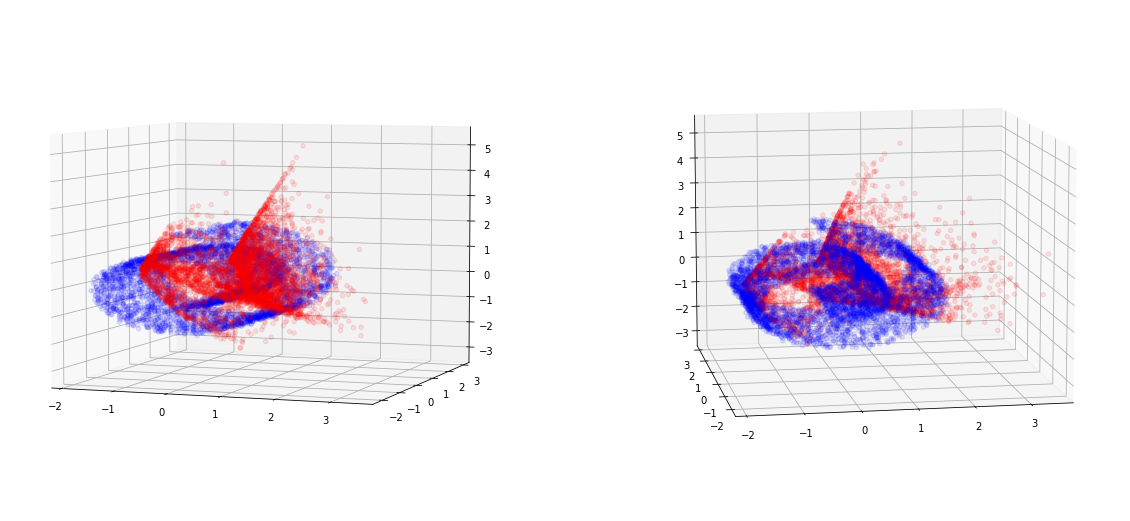

In [94]:
GANdata = myGAN.g(t.randn([5000,dimZ])).detach().numpy()
plt.rcParams['figure.figsize'] = [20, 20]
plt.clf()
ax = plt.subplot(1,2,1, projection='3d')

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c = 'blue', alpha = 0.1)
ax.scatter(GANdata[:, 0], GANdata[:, 1], GANdata[:, 2], c='red' , alpha = 0.1)
ax.view_init(5, -70)

ax = plt.subplot(1,2,2, projection='3d')

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c = 'blue', alpha = 0.1)
ax.scatter(GANdata[:, 0], GANdata[:, 1], GANdata[:, 2], c = 'red' , alpha = 0.1)
ax.view_init(10, -100)



The code below plots **just** the GAN generated data (you may wish to use it if the above plot makes it difficult to see what is happening)

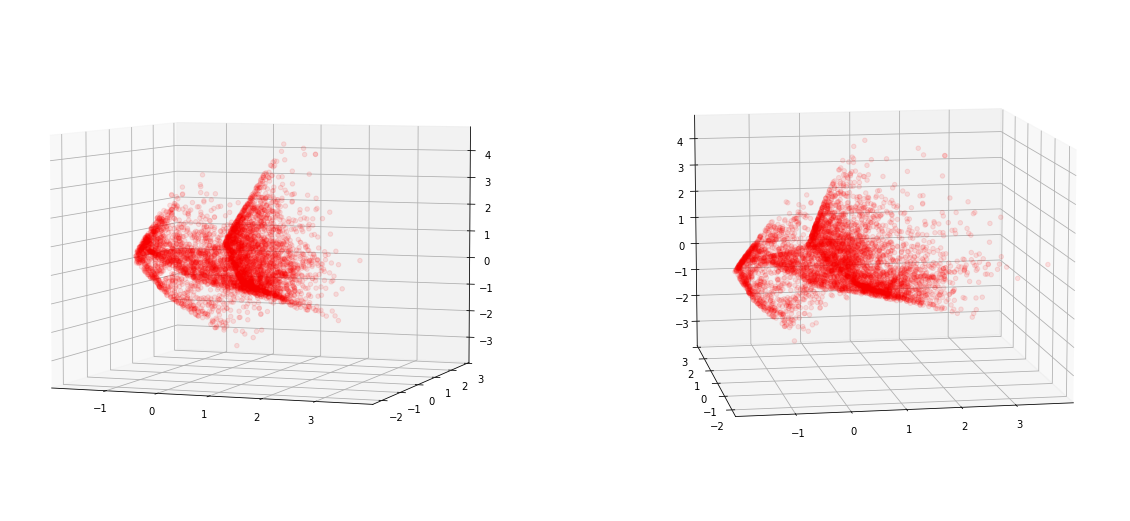

In [92]:
plt.clf()
ax = plt.subplot(1,2,1, projection='3d')
ax.scatter(GANdata[:, 0], GANdata[:, 1], GANdata[:, 2], c = 'red', alpha = 0.1)
ax.view_init(5, -70)

ax = plt.subplot(1,2,2, projection='3d')
ax.scatter(GANdata[:, 0], GANdata[:, 1], GANdata[:, 2], c = 'red', alpha = 0.1)
ax.view_init(10, -100)